In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import qtensor.states as states 
import qtensor.operators as ops
from qtensor.simulation.finiteTDVP import tdvp, right_mpo_contractions, gs_evolve
import qtensor.simulation.finiteTDVP as sim
import qtensor.thermofield as thf 
import ncon

Basic state

In [2]:
N=10
D=6

psi = states.random_mps(N, 2, D, seed=42)
psi.right_canonical()

H = ops.tilted_ising(N=N)
H_term = ops.extensive_twosite_local_term(H, 3)

H_spin_up = ops.tilted_ising(J=0, h=1, g=0, N=N)


Simple TDVP

Initiating TDVP
TDVP finished!
Method: method_exact, Time taken: 3.72 seconds


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


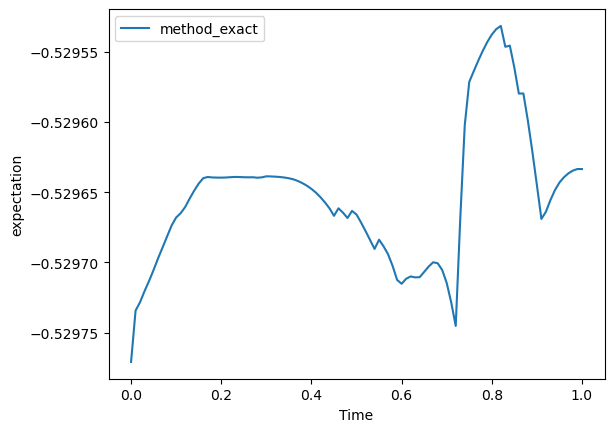

In [3]:
import time

t_f = 1
steps = 100
methods = [sim.method_exact]

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Time')
ax.set_ylabel('expectation')
for method in methods:
    psi_copy = copy.deepcopy(psi)
    ti = time.time()
    s_hist, _ = tdvp(psi_copy, H, t_f, steps, method=method, history=True)
    t_real = time.time() - ti
    print(f"Method: {str(method).split()[1]}, Time taken: {t_real:.2f} seconds")   
    t = list(s_hist.keys())
    expecs = [ops.local_expect(state, H_term) for state in s_hist.values()]
    ax.plot(t, expecs, label=str(method).split()[1])
ax.legend()


Ground state evolve

In [4]:
psi = gs_evolve(psi, H_spin_up, 1000, 100)

Intial energy: (-0.24798775449688892+4.1199682554448774e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-9.99999981771035+9.360645398083498e-16j)


Thermofield stuff

In [5]:
N = 8
D = 8
H_usual = ops.tilted_ising(N=N)
beta = 1
H_th = thf.thermofield_hamiltonian(H_usual)


Intial energy: (-7.9589934546395655-8.371901976209293e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-23.99999999999999+2.1371793224034263e-15j)
Initiating TDVP
TDVP finished!
Energy at finite temperature: -7.627133944402408


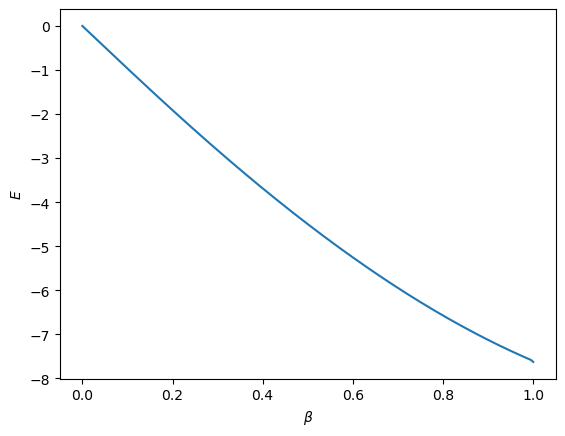

In [6]:
beta_psi, times, energies = thf.finite_T_thermofield(beta, N, D, H_th, steps=200)

In [7]:
# compare this to the groundstate energy
randpsi = states.random_mps(N, 2, D)
gs_evolve(randpsi, H_usual)

Intial energy: (-4.162048062445335-4.426325008087262e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-9.590983998497517+3.469446951953614e-16j)


Testing near thermal ansatz builder

In [ ]:
N = 24
D = 8
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_check_before = copy.deepcopy(H_tf[2])
H_middle = ops.extensive_twosite_local_term(H_tf, int((N-1)/2))
H_check_after = copy.deepcopy(H_tf[2])

assert np.allclose(H_check_before, H_check_after), "The two Hamiltonians should be equal before the contraction."

beta_avg = 0.05
delta_beta = 0.001
sigma = 1

In [63]:
inf_T_state = sim.inf_T_thermofield_variational(N, D, 1000, 250, seed=1)

Intial energy: (-24.487033537313728+3.8368083264764656e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-72.00000000000006-2.5396351688300456e-15j)


Initiating TDVP
TDVP finished!
Energy at finite temperature: -1.5715187756473024


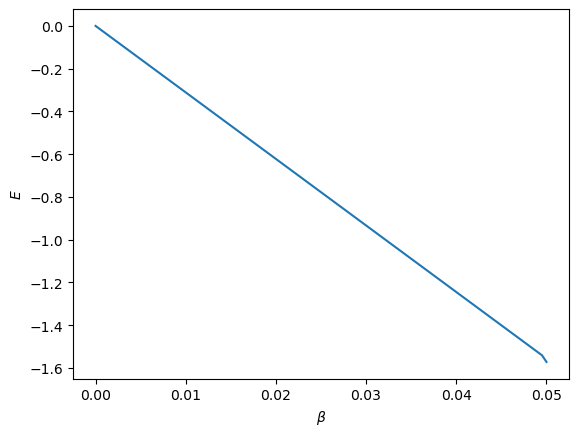

In [64]:
working_state = copy.deepcopy(inf_T_state)
even_state = thf.finite_T_thermofield(beta_avg, N, D, H_tf, initial_state=working_state)[0]

In [65]:
# gaussian profile ontop of an average, 
# with temp highest at centre,
# adjusted to have zero mean
# d_beta_profile = delta_beta*np.exp(-(np.linspace(-N/2, N/2, N)**2)/(2*sigma**2))

# cosine profile
k = 0.5
d_beta_profile = delta_beta*np.cos(-k*np.linspace(-N/2, N/2, N))

d_beta_profile = d_beta_profile - np.mean(d_beta_profile)*np.ones(N)

beta_profile = beta_avg*np.ones(N) - d_beta_profile
 
working_state = copy.deepcopy(inf_T_state)
profile_state = thf.near_thermal(H_tf, beta_profile, D, initial_state=working_state)

Initiating TDVP
TDVP finished!


In [66]:
# Checking energy along chain
inft_energy = []
local_energy = []
even_energy = []
sites = sorted(list(H_usual.sites))
local_ops = ops.extensive_as_terms(H_tf)
for term in local_ops:
    inft_energy.append(ops.local_expect(inf_T_state, term))
    local_energy.append(ops.local_expect(profile_state, term))
    even_energy.append(ops.local_expect(even_state, term))

Text(0.5, 0, 'Bond')

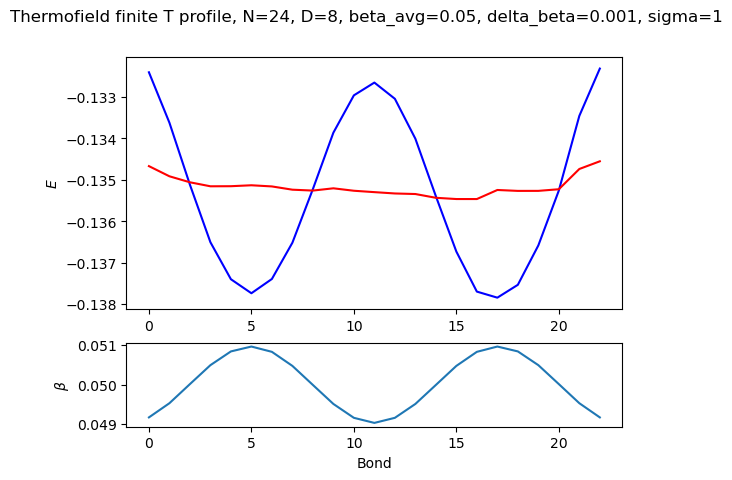

In [67]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1])
# ax[0,].plot(sites[:-1], inft_energy, color='k', label='Infinite T')
fig.suptitle(f"Thermofield finite T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b', label='Profile T')
ax[0,].plot(sites[:-1], even_energy, color='r', label='Finite T')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")

Do real time evolution on almost-thermal state

In [68]:
initial_state = copy.deepcopy(profile_state)
t_f = 1.5
n_steps = 150
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state,
 H_tf, t_f, n_steps, sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_tf, H_middle])


Initiating TDVP
t: 0.000
t: 0.010
t: 0.020
t: 0.030
t: 0.040
t: 0.050
t: 0.060
t: 0.070
t: 0.080
t: 0.090
t: 0.100
t: 0.110
t: 0.120
t: 0.130
t: 0.140
t: 0.150
t: 0.160
t: 0.170
t: 0.180
t: 0.190
t: 0.200
t: 0.210
t: 0.220
t: 0.230
t: 0.240
t: 0.250
t: 0.260
t: 0.270
t: 0.280
t: 0.290
t: 0.300
t: 0.310
t: 0.320
t: 0.330
t: 0.340
t: 0.350
t: 0.360
t: 0.370
t: 0.380
t: 0.390
t: 0.400
t: 0.410
t: 0.420
t: 0.430
t: 0.440
t: 0.450
t: 0.460
t: 0.470
t: 0.480
t: 0.490
t: 0.500
t: 0.510
t: 0.520
t: 0.530
t: 0.540
t: 0.550
t: 0.560
t: 0.570
t: 0.580
t: 0.590
t: 0.600
t: 0.610
t: 0.620
t: 0.630
t: 0.640
t: 0.650
t: 0.660
t: 0.670
t: 0.680
t: 0.690
t: 0.700
t: 0.710
t: 0.720
t: 0.730
t: 0.740
t: 0.750
t: 0.760
t: 0.770
t: 0.780
t: 0.790
t: 0.800
t: 0.810
t: 0.820
t: 0.830
t: 0.840
t: 0.850
t: 0.860
t: 0.870
t: 0.880
t: 0.890
t: 0.900
t: 0.910
t: 0.920
t: 0.930
t: 0.940
t: 0.950
t: 0.960
t: 0.970
t: 0.980
t: 0.990
t: 1.000
t: 1.010
t: 1.020
t: 1.030
t: 1.040
t: 1.050
t: 1.060
t: 1.070
t: 1.080
t: 

Text(0.5, 0.98, 'Time-evolved T profile, N=24, D=8, beta_avg=0.05, delta_beta=0.001, sigma=1')

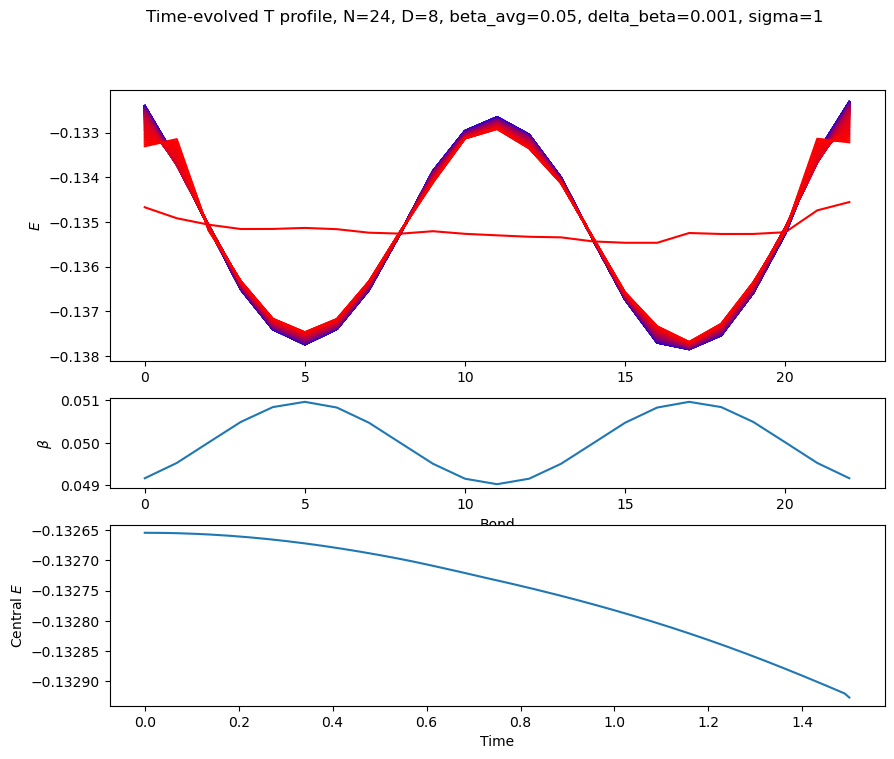

In [69]:
fig, ax = plt.subplots(3, 1, height_ratios=[3, 1, 2], figsize=(10, 8))
fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b')
ax[0,].plot(sites[:-1], even_energy, color='r')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")


times = evolved_state.keys()
E_profile={}
for t in times:
    if t < 1.5:
        E_profile[t] = [ops.local_expect(evolved_state[t], op) for op in local_ops]
        ax[0,].plot(sites[:-1], E_profile[t], color=(t/t_f, 0, 1-t/t_f))


middle_energy = [expectations[t][1] for t in times]
ax[2,].plot(list(times)[:300], middle_energy[:300])
ax[2,].set_xlabel("Time")
ax[2,].set_ylabel(r'Central $E$')

fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")


Energy derivative

Text(0, 0.5, '$\\Delta E$')

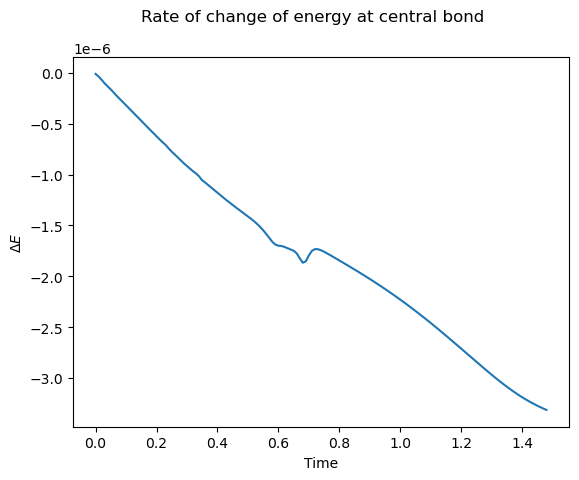

In [70]:
E_diff = np.array(middle_energy[1:]) - np.array(middle_energy[:-1])
fig, ax = plt.subplots(1, 1)
ax.plot(list(times)[:-2], E_diff[:-1])
fig.suptitle(f"Rate of change of energy at central bond")
ax.set_xlabel("Time")
ax.set_ylabel(r'$\Delta E$')

Creating Dictionary of temperatures an equillibrium energy density

In [41]:
N = 8
D = 4
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_middle = ops.extensive_twosite_local_term(H_tf, int((N-1)/2))
H_terms = ops.extensive_as_terms(H_tf)

beta_max = 0.1
beta_range = np.linspace(0, beta_max, 11)
energies = {}

In [42]:
inf_T_state = sim.inf_T_thermofield_variational(N, D, 1000, 100, seed=1)

Intial energy: (-6.6221444045261375-1.1894156022472871e-15j)
Initiating TDVP
TDVP finished!
Final energy: (-24.00000000000002+2.7755575615628914e-17j)


Beta: 0.0
Initiating TDVP
TDVP finished!
Energy: (-2.1320280708059725e-17+5.377257808582164e-32j)
Beta: 0.01
Initiating TDVP


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


TDVP finished!
Energy: (-0.013533678306705807-8.663431679016187e-19j)
Beta: 0.02
Initiating TDVP
TDVP finished!
Energy: (-0.02710255411651776+1.0400915586099864e-18j)
Beta: 0.03
Initiating TDVP
TDVP finished!
Energy: (-0.04070359730289416-6.773168493835018e-19j)
Beta: 0.04
Initiating TDVP
TDVP finished!
Energy: (-0.054333810838364666-1.5862266867235617e-19j)
Beta: 0.05
Initiating TDVP
TDVP finished!
Energy: (-0.06799023563885517-1.107242957724095e-19j)
Beta: 0.06
Initiating TDVP
TDVP finished!
Energy: (-0.08166995505713984-2.3275302507648914e-19j)
Beta: 0.07
Initiating TDVP
TDVP finished!
Energy: (-0.09537009910747325-2.457432352401738e-19j)
Beta: 0.08
Initiating TDVP
TDVP finished!
Energy: (-0.10908784828528015+2.0604985742788823e-18j)
Beta: 0.09
Initiating TDVP
TDVP finished!
Energy: (-0.12282043699661363-2.877794185403186e-19j)
Beta: 0.1
Initiating TDVP
TDVP finished!
Energy: (-0.13656515655644974-5.297619015463828e-19j)


Text(0, 0.5, '$E$')

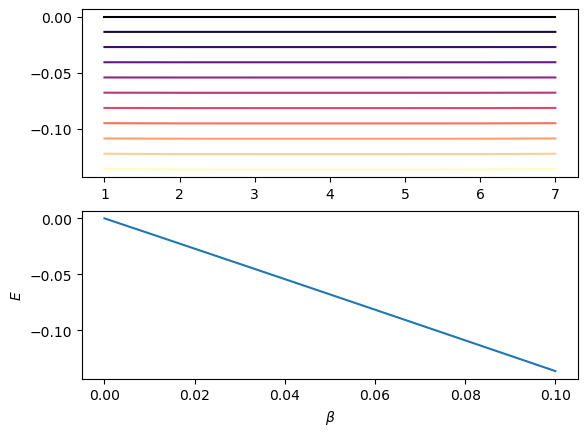

In [43]:
import matplotlib as mpl
cmap = mpl.colormaps['magma']

fig, ax = plt.subplots(2, 1)

for beta in beta_range:
    print(f"Beta: {beta}")
    working_state = copy.deepcopy(inf_T_state)
    beta_state = thf.finite_T_thermofield(beta, N, D, H_tf, 
                                          initial_state=working_state,
                                          plot=False, 
                                          method=sim.method_exact)[0]
    local_energies = [ops.local_expect(beta_state, term)/2 for term in H_terms] #remember factor of 2 for thermofield
    
    energies[beta] = np.mean(local_energies[int(N/4):int(3*N/4)])  # Average over the middle half of the chain
    print(f"Energy: {energies[beta]}")
    ax[0].plot(np.arange(1, N), local_energies, 
               color=cmap(beta/beta_max))


ax[1].plot(beta_range, list(energies.values()))
ax[1].set_xlabel(r"$\beta$")
ax[1].set_ylabel(r"$E$")



In [44]:
(energies[beta_max]/beta_max)

(-1.3656515655644974-5.297619015463828e-18j)

In [2]:
J=1
h=0.25
g=-0.525
print((J**2 + 0.5*(h**2 + g**2)))

1.1690625


Testing how long 'thermal' state stays looking normal before instabilities go crazy


In [33]:
N = 12
D = 8
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_terms = ops.extensive_as_terms(H_tf)

inf_t_state = sim.inf_T_thermofield_variational(N, D, 1000, 10, seed=1)

Intial energy: (-12.396199025634644-1.0665254453627392e-15j)
Initiating TDVP
TDVP finished!
Final energy: (-35.99999999999986+3.858025010575246e-15j)


Initiating TDVP
TDVP finished!
Energy at finite temperature: -1.525987446014214


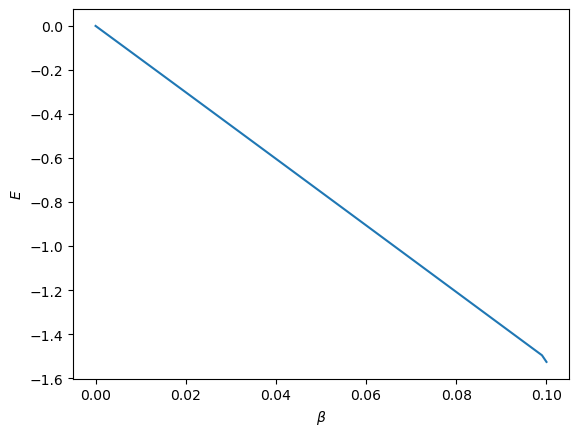

In [34]:
beta = 0.1
beta_state = thf.finite_T_thermofield(beta, N, D, H_tf, initial_state=inf_t_state)[0]

In [35]:
initial_state = copy.deepcopy(beta_state)
t_f = 1
n_steps = 100
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state,
                                       H_tf, 
                                       t_f, 
                                       n_steps, 
                                       sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_tf])


Initiating TDVP
t: 0.000
t: 0.010
t: 0.020
t: 0.030
t: 0.040
t: 0.050
t: 0.060
t: 0.070
t: 0.080
t: 0.090
t: 0.100
t: 0.110
t: 0.120
t: 0.130
t: 0.140
t: 0.150
t: 0.160
t: 0.170
t: 0.180
t: 0.190
t: 0.200
t: 0.210
t: 0.220
t: 0.230
t: 0.240
t: 0.250
t: 0.260
t: 0.270
t: 0.280
t: 0.290
t: 0.300
t: 0.310
t: 0.320
t: 0.330
t: 0.340
t: 0.350
t: 0.360
t: 0.370
t: 0.380
t: 0.390
t: 0.400
t: 0.410
t: 0.420
t: 0.430
t: 0.440
t: 0.450
t: 0.460
t: 0.470
t: 0.480
t: 0.490
t: 0.500
t: 0.510
t: 0.520
t: 0.530
t: 0.540
t: 0.550
t: 0.560
t: 0.570
t: 0.580
t: 0.590
t: 0.600
t: 0.610
t: 0.620
t: 0.630
t: 0.640
t: 0.650
t: 0.660
t: 0.670
t: 0.680
t: 0.690
t: 0.700
t: 0.710
t: 0.720
t: 0.730
t: 0.740
t: 0.750
t: 0.760
t: 0.770
t: 0.780
t: 0.790
t: 0.800
t: 0.810
t: 0.820
t: 0.830
t: 0.840
t: 0.850
t: 0.860
t: 0.870
t: 0.880
t: 0.890
t: 0.900
t: 0.910
t: 0.920
t: 0.930
t: 0.940
t: 0.950
t: 0.960
t: 0.970
t: 0.980
t: 0.990
t: 1.000
TDVP finished!


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


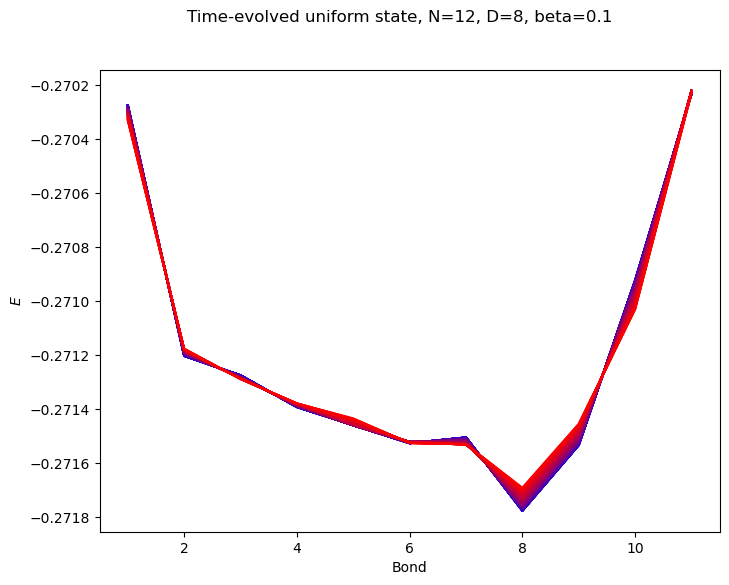

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle(f"Time-evolved uniform state, N={N}, D={D}, beta={beta}")

ax.set_ylabel(r'$E$')
ax.set_xlabel("Bond")

times = evolved_state.keys()
E_profile={}
for t in times:
    if t < t_f:
        E_profile[t] = [ops.local_expect(evolved_state[t], term)
                        for term in H_terms]
        ax.plot(np.arange(1,N), E_profile[t], color=(t/t_f, 0, 1-t/t_f))



In [37]:
times


dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0])